In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = pd.read_csv('renfe.csv')

for i in ['insert_date','start_date','end_date']:
    data[i] = pd.to_datetime(data[i])

#clean the missing data
data['price'] = data['price'].fillna(data['price'].mean())
data = data.dropna()

#change start time and end time to be together
data['start_end_hour'] = data['end_date'] - data['start_date']
data['start_end_hour'] = data['start_end_hour']/np.timedelta64(1,'h')
data['insert_month'] = data['insert_date'].dt.month
data['insert_day'] = data['insert_date'].dt.day
data['insert_hour'] = data['insert_date'].dt.hour
data['insert_min'] = data['insert_date'].dt.minute
data['insert_sec'] = data['insert_date'].dt.second

data = data.drop(['insert_date','start_date','end_date'],1)

#change the categrorical to numberical
one_hot_encoding = pd.get_dummies(data[['origin','destination','train_type','train_class','fare']])
data = data.drop(['origin','destination','train_type','train_class','fare'],1)
data = pd.concat([one_hot_encoding, data], axis=1)
data = data.astype(np.float)

X = data.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
                  ,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,
                  39,40,41,42,43,44,46,47,48,49,50,51]]
Y = data.iloc[:, [45]]


X_train1, X_test1, y_train1, y_test1 = train_test_split(X.values, Y.values, test_size=.9, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size=.1, random_state=42)

Splite the data because the data is too large, so we splite twice. First is train:test=1:9. Second is train:test = 9:1

In [4]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)
R2 = r2_score(y_test, y_pred)
print(R2)
score_train = model.score(X_train, y_train)
print(score_train)
score_test = model.score(X_test,y_test)
print(score_test)

129.33283508249076
0.7904647020841641
0.7859795785845033
0.790464702084164


Find parameter of Ridge

In [7]:
parameter = {'alpha':[1e-3,1e-2,1,10,20]}
ridge = Ridge()
ridge.fit(X_train, y_train)
gs = GridSearchCV(estimator=ridge, param_grid=parameter, cv= 5)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7858019613520318
{'alpha': 10}


The coefficient of Ridge weight

In [66]:
final_ridge = Ridge(alpha=10)
final_ridge.fit(X_train,y_train)
final_ridge1 = pd.DataFrame(data=final_ridge.coef_)
final_ridge2 = []
for i in range(51):
    final_ridge2.append(final_ridge1[i].values)
final_ridge3 = pd.DataFrame(final_ridge2)
label = data.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
                  ,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,
                  39,40,41,42,43,44,46,47,48,49,50,51]]
coef = pd.Series(final_ridge3[0].values, index = label)
imp_coef = coef.sort_values()
print(imp_coef)

train_type_R. EXPRES                   -33.007379
fare_COD.PROMOCIONAL                   -28.548760
train_class_Turista con enlace         -27.073626
fare_Promo                             -23.420259
train_type_INTERCITY                   -13.836397
train_type_REGIONAL                    -13.794773
origin_VALENCIA                        -13.266705
destination_PONFERRADA                 -13.207476
fare_Promo +                           -12.776367
destination_VALENCIA                   -12.630830
train_class_TuristaSólo plaza H        -11.556222
origin_PONFERRADA                      -10.604849
train_type_TRENHOTEL                   -10.445171
train_class_Turista                     -9.396352
train_type_LD-AVE                       -8.910490
fare_Adulto ida                         -7.895812
train_type_ALVIA                        -7.011264
train_type_AV City                      -6.401363
origin_SEVILLA                          -3.614979
start_end_hour                          -3.235447


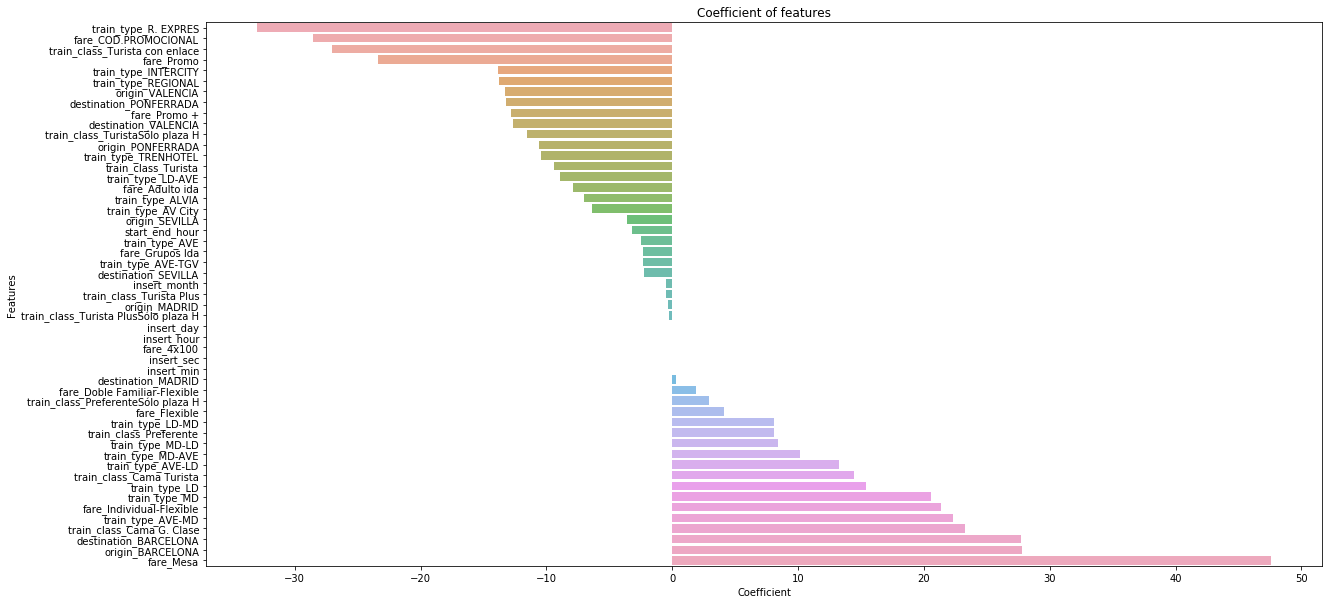

In [67]:
plt.figure(figsize=(20,10))
sns.barplot(imp_coef.values, imp_coef.index, alpha=0.8)
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Coefficient of features')
plt.show()

Learning curve

In [19]:
cv=ShuffleSplit(n_splits=10,test_size=0.1,random_state=42)

def plot_curve():
    # instantiate
    model_linear = LinearRegression()

    # fit
    model_linear.fit(X_train1, y_train1)
    
    train_sizes, train_scores, test_scores = learning_curve(model_linear, X_train1, y_train1, 
                                                            n_jobs=-1, cv=cv, 
                                                            train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit, ax=plt.subplots()
    #plt.figure()
    ax.set_title("Linear regression")
    ax.legend(loc="best")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    #ax.gca().invert_yaxis()
    
    # box-like grid
    ax.grid()
    
    # plot the std deviation as a transparent range at each training set size
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    ax.set_ylim(0.5,1)
    legend = ax.legend()
    plt.show()

/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
No handles with labels found to put in legend.


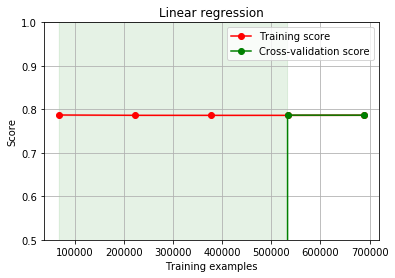

In [20]:
plot_curve()